# LSTM Forecasting practice

## Importing Data

In [5]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np

In [7]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
df = pd.read_csv(csv_path)

## Preparing Data for Split

In [17]:
df = df[5: :6] #Takes every hour only
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [32]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

<Axes: xlabel='Date Time'>

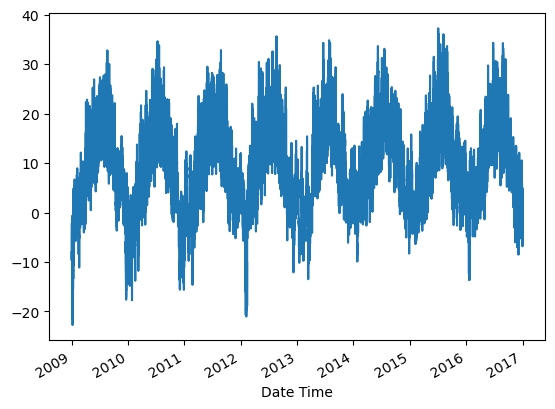

In [34]:
temp = df['T (degC)']
temp.plot()

## Creating X and y for LSTM

In [42]:
# [[[1], [2], [3] ,[4] ,[5]]] [6]
# [[[2], [3], [4], [5] ,[6]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size ):  #5 in example
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [[a] for a in df_as_np[i: i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [50]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
print(X.shape)
print(y.shape)

(70086, 5, 1)
(70086,)


## Train Val Test Split

In [58]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

## Creating Model

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

## Creating checkpoint callback for saving best model

In [64]:
cp = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [66]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 95.8128 - root_mean_squared_error: 9.6427 - val_loss: 1.5135 - val_root_mean_squared_error: 1.2302
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.9405 - root_mean_squared_error: 1.9702 - val_loss: 0.6796 - val_root_mean_squared_error: 0.8244
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2362 - root_mean_squared_error: 1.1098 - val_loss: 0.5620 - val_root_mean_squared_error: 0.7497
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8138 - root_mean_squared_error: 0.9019 - val_loss: 0.5286 - val_root_mean_squared_error: 0.7270
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7059 - root_mean_squared_error: 0.8401 - val_loss: 0.5069 - val_root_mean_squared_error: 0.7120
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6877 - root_mean_squared_error: 0.8292 - val_loss: 0.5010 - val_root_mean_squared_error: 0.7078
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━

## Making predications

In [68]:
from tensorflow.keras.models import load_model
model1 = load_model('model1.keras')

In [72]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train})

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [74]:
train_results

,Train Predictions,Actuals
0,-9.894965,-9.67
1,-9.773208,-9.17
2,-8.956336,-8.10
3,-7.491269,-7.66
4,-7.247899,-7.04
...,...,...
59995,6.002632,6.07
59996,7.143868,9.88
59997,12.310466,13.53
59998,15.996952,15.43


## Train vs Actual

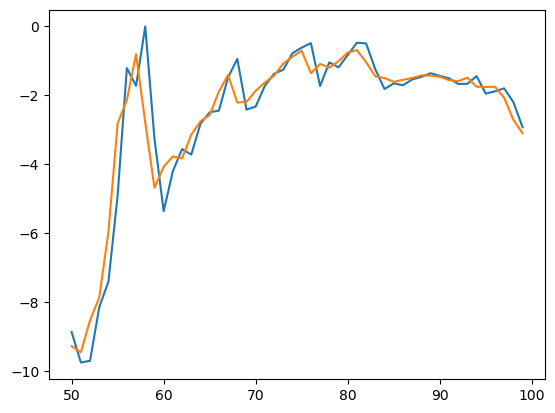

In [84]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

## Val vs Actual

In [86]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals': y_val})
val_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Val Predictions,Actuals
0,15.342909,14.02
1,13.160327,13.67
2,12.931830,12.27
3,11.400573,11.19
4,10.287984,10.85
...,...,...
4995,17.153580,18.27
4996,17.226042,17.85
4997,17.122683,16.65
4998,15.749251,15.85


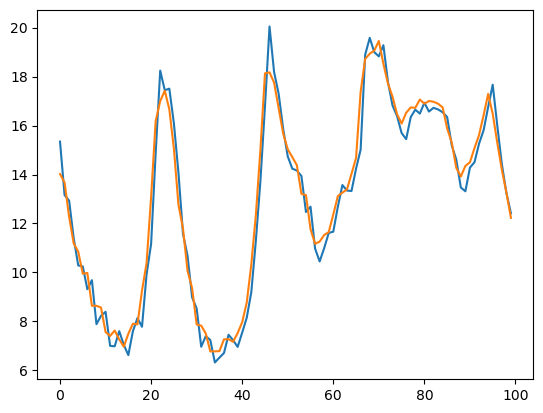

In [88]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

## Test vs Actual

In [90]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test})
test_results

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Test Predictions,Actuals
0,14.295817,13.99
1,13.151958,13.46
2,12.767972,12.93
3,12.367493,12.43
4,11.923553,12.17
...,...,...
5081,-1.144021,-0.98
5082,-1.426888,-1.40
5083,-1.791227,-2.75
5084,-3.141763,-2.89


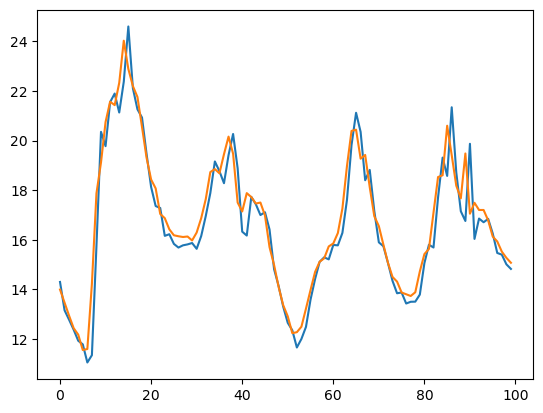

In [94]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])